## Facial Keypoints Detection

- about competition: https://www.kaggle.com/c/facial-keypoints-detection
- data: https://www.kaggle.com/c/facial-keypoints-detection/data
- leaderboard: https://www.kaggle.com/c/facial-keypoints-detection/leaderboard
- my best submission: 

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
import matplotlib.pyplot as plt

%matplotlib inline

Get data

In [2]:
df_train_src = pd.read_csv('data/training.csv')
df_test_src = pd.read_csv('data/test.csv')

print df_train_src.info()
df_train_src.head(3).T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

,0,1,2
left_eye_center_x,66.0336,64.3329,65.0571
left_eye_center_y,39.0023,34.9701,34.9096
right_eye_center_x,30.227,29.9493,30.9038
right_eye_center_y,36.4217,33.4487,34.9096
left_eye_inner_corner_x,59.5821,58.8562,59.412
left_eye_inner_corner_y,39.6474,35.2743,36.321
left_eye_outer_corner_x,73.1303,70.7227,70.9844
left_eye_outer_corner_y,39.97,36.1872,36.321
right_eye_inner_corner_x,36.3566,36.0347,37.6781
right_eye_inner_corner_y,37.3894,34.3615,36.321


In [3]:
images = df_train_src['Image'].str.split().apply(pd.Series)
images.columns = ['px_' + str(x) for x in range(9216)]
images.head()

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_9206,px_9207,px_9208,px_9209,px_9210,px_9211,px_9212,px_9213,px_9214,px_9215
0,238,236,237,238,240,240,239,241,241,243,...,33,29,30,34,39,49,62,70,75,90
1,219,215,204,196,204,211,212,200,180,168,...,1,1,1,1,1,1,1,1,1,1
2,144,142,159,180,188,188,184,180,167,132,...,64,60,56,61,70,69,71,78,78,77
3,193,192,193,194,194,194,193,192,168,111,...,1,1,1,1,1,1,1,1,1,1
4,147,148,160,196,215,214,216,217,219,220,...,33,34,37,37,43,46,83,140,170,176


In [4]:
points = df_train_src.copy(deep=True)
_ = points.pop('Image')

Visualize data

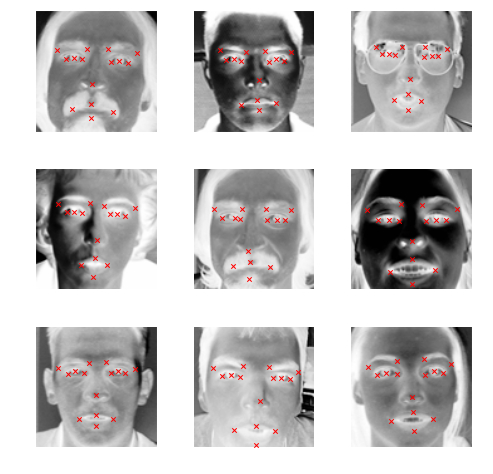

In [5]:
samples = 3
idx = 0
for x in xrange(samples):
    for y in xrange(samples):
        f = plt.figure(samples*samples)
        f.set_figheight(8)
        f.set_figwidth(8)
        plt_idx = y * samples + x + 1
        plt.subplot(samples, samples, plt_idx)
        plt.imshow(images.values[idx].reshape(96, 96).astype(float), cmap='Greys')
        plt.scatter(points.values[idx][range(0,30,2)], points.values[idx][range(1,30,2)], c='r', marker='x')
        plt.axis("off")
        idx += 1
plt.show()